<a href="https://colab.research.google.com/github/yeolives/D.N.A/blob/master/apt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [금융] 아파트 실거래가 예측 대회
### with 머신러닝
---
- [데이콘](https://dacon.io/competitions/open/235537/overview/) 에서 제공해주는 교육 DATA
- 분석 및 모델 : [WooYeol Shim](https://github.com/yeolives), SooYoung Ko, SoYoung Yu
- - -


#### 1. DATA load

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')


import os
os.chdir("D:\\DATA\\apt")

os.listdir()
train_origin = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#park = pd.read_csv("park.csv")
#center = pd.read_csv("day_care_center.csv")
sub = pd.read_csv("submission.csv")

train = train_origin.copy()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### 2. EDA

In [ ]:
#결측값은 없다.
train.isnull().sum()

transaction_id            0
apartment_id              0
city                      0
dong                      0
jibun                     0
apt                       0
addr_kr                   0
exclusive_use_area        0
year_of_completion        0
transaction_year_month    0
transaction_date          0
floor                     0
transaction_real_price    0
dtype: int64

In [ ]:
#4분위수 보기
train.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


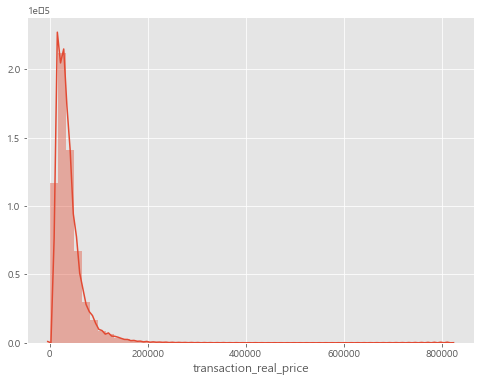

In [ ]:
# count의 값은 너무 왜곡도 심하고 값차이도 크기 때문에 log정규화를 해놓고 진행하겠읍니다.
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(train['transaction_real_price'])

*집단별 정확한 비교를 위해 면적당 거래액으로 비교 진행*

In [ ]:
train['per_price'] = np.round(train.transaction_real_price / train.exclusive_use_area,2)

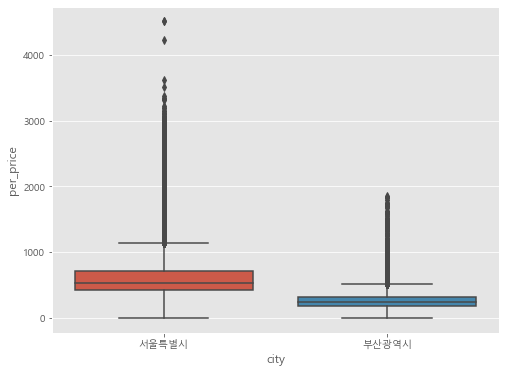

In [ ]:
#1. 도시

f, ax = plt.subplots(figsize = (8,6))
sns.boxplot(train['city'], train['per_price'],hue_order=True)
plt.show()

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


#독립표본 t검정
model = ols('per_price ~ C(city)', train).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(city),1.0,3.802008e+10,3.802008e+10,671017.131605,0.0
Residual,1216551.0,6.893022e+10,5.666036e+04,NaN,NaN


p-value = 0.0으로 두 도시의 평균의 차이는 유의하다

---

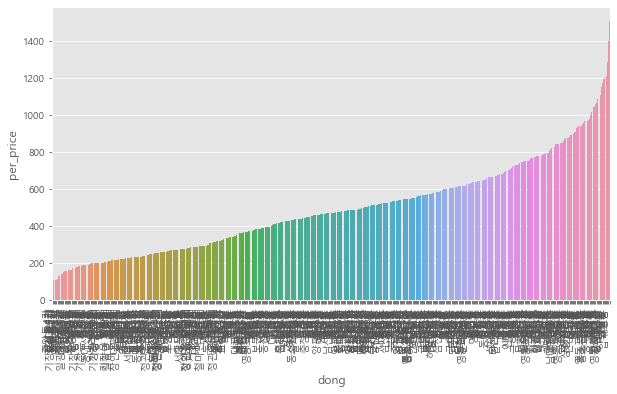

In [ ]:
#2.동
m = train.groupby(['dong'])['per_price'].mean().reset_index().sort_values(['per_price'])
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=m, x='dong', y='per_price', )
f.autofmt_xdate(rotation=90)

---

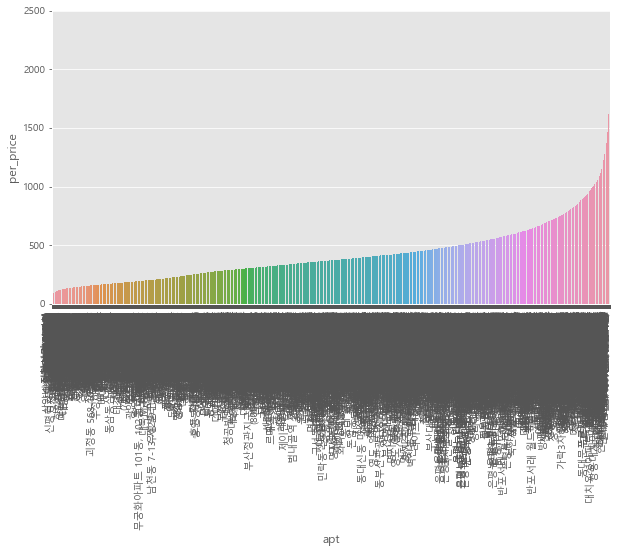

In [ ]:
#3.아파트
a = train['per_price'].groupby(train.apt).mean().reset_index().sort_values(['per_price'])
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=a, x='apt', y='per_price', )
f.autofmt_xdate(rotation=90)

---

In [ ]:
#4.층(일원배치분산분석)
model = ols('per_price ~ C(floor)', train).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(floor),83.0,6.707352e+08,8.081147e+06,92.496287,0.0
Residual,1216469.0,1.062796e+11,8.736726e+04,NaN,NaN


p-value = 0.0으로 층마다의 의 평균의 차이가 있다고 할 수 있음

---

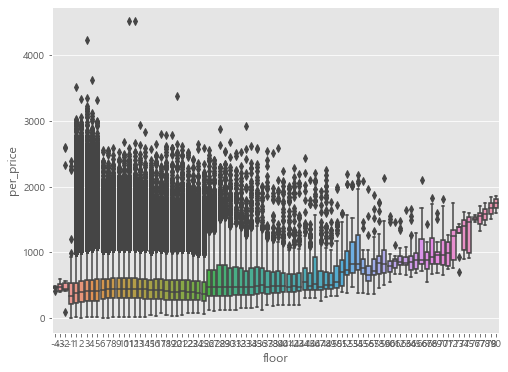

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
sns.boxplot(train['floor'], train['per_price'])
plt.show()

#### *상관관계 히트맵*

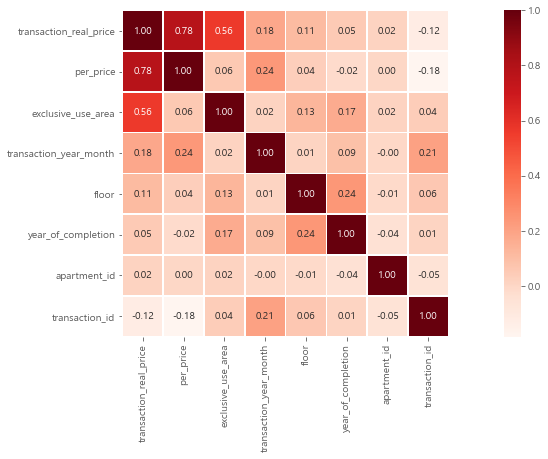

In [ ]:
#상관관계 확인
k=train.shape[1] #히트맵 변수 갯수
corrmat = train.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

#### 3. Preprocessing

In [ ]:
train['log_price']=np.log1p(train.transaction_real_price)

df = pd.concat([train,test],axis=0)

파생변수
1. 거래년도 - 완공년도
2. 재건축여부

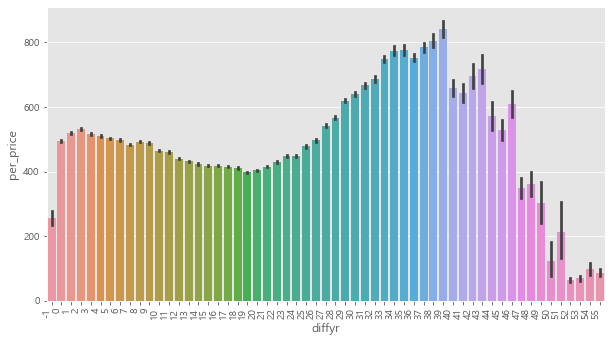

In [ ]:
df['month'] = df.transaction_year_month.apply(lambda x : int(str(x)[4:6]))
df['year'] = df.transaction_year_month.apply(lambda x : int(str(x)[:4]))
#거래년도 - 완공년도
df['diffyr'] = df.year - df.year_of_completion
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=train, x='diffyr', y='per_price')
f.autofmt_xdate(rotation=90)

In [ ]:
df['old'] = (df.diffyr >= 30).astype('int')

model = ols('per_price ~ C(old)', df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(old),1.0,4.864936e+09,4.864936e+09,57975.434916,0.0
Residual,1216551.0,1.020854e+11,8.391375e+04,NaN,NaN


In [ ]:
#라벨링
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()

#동
label.fit(df['dong'])
df['dong']=label.transform(df['dong'])

#apt
label.fit(df['apt'])
df['apt']=label.transform(df['apt'])

#city
label.fit(df['city'])
df['city']=label.transform(df['city'])

In [ ]:
test.columns

Index(['transaction_id', 'apartment_id', 'city', 'dong', 'jibun', 'apt',
       'addr_kr', 'exclusive_use_area', 'year_of_completion',
       'transaction_year_month', 'transaction_date', 'floor',
       'transaction_real_price', 'per_price', 'log_price', 'month', 'year',
       'diffyr'],
      dtype='object')

In [ ]:
train = df[df.log_price.isnull()==False]
target = train.log_price
test = df[df.log_price.isnull()].reset_index(drop=True)
te = test.loc[:,['apartment_id', 'city', 'dong','exclusive_use_area','floor','diffyr','old']]

In [ ]:
#여러 모델 비교
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


target = train.log_price
tr = train.loc[:,['apartment_id', 'city', 'dong','exclusive_use_area',
       'floor','diffyr','old']]

#cross validation score
n_folds = 5

def cv_score(models):
    kfold = KFold(n_splits=n_folds, shuffle=True ,random_state=42).get_n_splits(tr.values)
    for m in models:
        cvs = np.mean(cross_val_score(m['model'], tr.values, target, cv=kfold))  # 아래서 바로 exp변환
        rmse = np.mean(np.sqrt(-cross_val_score(m['model'], tr.values, target, scoring = "neg_mean_squared_error", cv = kfold)))
        print("Model {} CV score : {:.4f}".format(m['name'], cvs))
        print("RMSLE : {:.4f}".format(rmse))

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=42))
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 0.0005, random_state=42))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))
gboost = GradientBoostingRegressor(random_state=42)
forest = RandomForestRegressor(random_state=42)
lightgbm = lgb.LGBMRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
#{'model': gboost, 'name':'GradientBoosting'},,{'model' : xgboost, 'name' : 'XGBOOST'}
models = [{'model':lightgbm, 'name':'LightGBM'},
          {'model' : lasso, 'name' : 'LASSO Regression'},{'model' : ridge, 'name' : 'Ridge Regression'}, {'model' : ENet, 'name' : 'Elastic Net Regression'} ]

cv_score(models)


Model LightGBM CV score : 0.6517
RMSLE : 0.3435
Model LASSO Regression CV score : 0.5260
RMSLE : 0.4121
Model Ridge Regression CV score : 0.5255
RMSLE : 0.4121
Model Elastic Net Regression CV score : 0.5260
RMSLE : 0.4121


In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

def print_best_params(model, params):
    grid_model = GridSearchCV(
            model,
            param_grid = params,
            cv=5,
            scoring='neg_mean_squared_error')
    
    grid_model.fit(tr, target)
    
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

lgb_params = {
    'num_leave' : [32,64],
    'max_depth' : [128,160],
    'n_estimators':[200],
    'max_bin' : [80,40],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 0.3545, 최적 alpha:{'gpu_id': 0, 'max_bin': 80, 'max_depth': 128, 'n_estimators': 200, 'num_leave': 32, 'predictor': 'gpu_predictor', 'refit': True, 'tree_method': 'gpu_hist'}


In [ ]:
lgb_preds = np.exp(lgb_estimator.predict(te))

In [ ]:
sub['transaction_real_price'] = lgb_preds